In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from pointprocess import *
import pointprocess.plotting as pplot
from lightning_setup import *
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
c = Region(city=cities['cedar'])
c.SUBSETTED = False
c.CENTER = (37.7, -111.8)
c.RADIUS = 0.7
c.define_grid()

version1 = pd.HDFStore('./output/Version1/store.h5')

In [3]:
storm = '2011-08-21'

In [4]:
ds = c.get_daily_ds(storm, filter_CG=dict(method='CG'))

## Map the storm to check it out

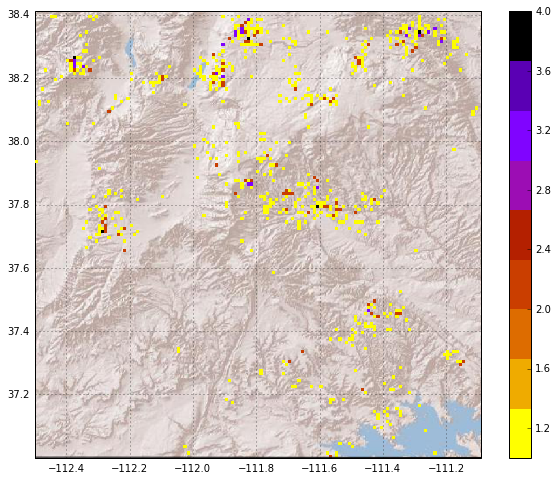

In [6]:
plt.figure(figsize=(10,8))
im, ax = c.plot_grid(cmap=cmap, vmin=1, cbar=True)
ax.add_image(pplot.ShadedReliefESRI(), 9)

## Conditional rate of occurrence

In [7]:
from geopy.distance import vincenty, great_circle
from math import radians, cos, sin, asin, sqrt, atan2, degrees

def bearing(pointA, pointB):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    And the bearing in 
    θ = atan2(sin(Δlong).cos(lat2),
          cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    """
    (lon1, lat1), (lon2, lat2) = pointA, pointB
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 

    x = sin(dlon) * cos(lat2)
    y = cos(lat1) * sin(lat2) - (sin(lat1) * cos(lat2) * cos(dlon))

    initial_bearing = atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [8]:
zero_time = pd.Timedelta(seconds=0).asm8
t_window = pd.Timedelta(minutes=15).asm8
dist_window = 20

In [9]:
lon = ds.lon.values
lat = ds.lat.values
time = ds.time.values

In [10]:
loc = np.stack([lon, lat]).T

In [11]:
%%time

dists = []
bearings = []
speeds = []
t_diffs = []
for t in time:
    t_diff = time-t
    bool_a = np.where((zero_time <= t_diff) & (t_diff< t_window))

    little_loc = np.take(loc, bool_a, axis=0)[0]
    little_t_diff = np.take(t_diff, bool_a)[0]
    for l, t in zip(little_loc[1:], little_t_diff[1:]):
        if (l == little_loc[0]).all():
            continue
        dist = great_circle(little_loc[0], l).km
        if dist < dist_window:
            hours = (int(t)/10e8/60/60.)
            t_diffs.append(hours)
            dists.append(dist)
            speeds.append(dist/hours)
            bearings.append(bearing(little_loc[0], l))

CPU times: user 819 ms, sys: 4.96 ms, total: 824 ms
Wall time: 822 ms


In [12]:
df = pd.DataFrame({'speed': speeds, 'direction':bearings})

In [13]:
df = df[df['speed'].abs()<200]

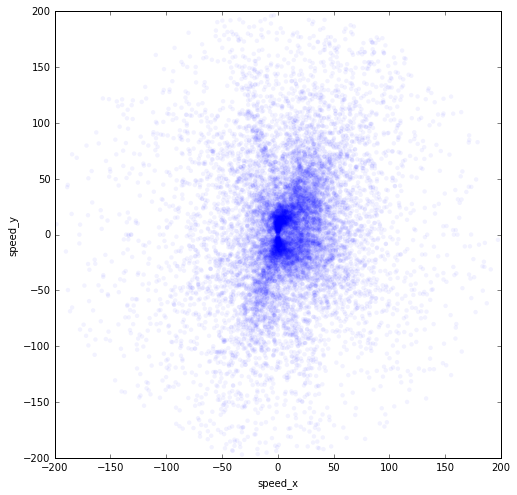

In [14]:
df['speed_x'] = df['speed'] * np.sin(np.radians(df['direction']))
df['speed_y'] = df['speed'] * np.cos(np.radians(df['direction']))
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
x0, x1 = ax.set_xlim(-200, 200)
y0, y1 = ax.set_ylim(-200, 200)
ax.set_aspect('equal')
_ = df.plot(kind='scatter', x='speed_x', y='speed_y', alpha=0.05, ax=ax, edgecolor='None')

In [16]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

from bokeh.plotting import figure, output_notebook, show

output_notebook()

x_range = y_range =(-200, 200)

plot_width=500
plot_height=500

def base_plot(tools='pan,wheel_zoom, box_zoom, reset',plot_width=plot_width, plot_height=plot_height,
              x_range=x_range, y_range=y_range, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = True
    return p

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'speed_x', 'speed_y', ds.count('speed_y'))
    img = tf.interpolate(agg, )
    return tf.dynspread(img, threshold=0.2, max_px=4)

p = base_plot()
InteractiveImage(p, create_image)

Loading BokehJS ...

In [17]:
from windrose import WindroseAxes

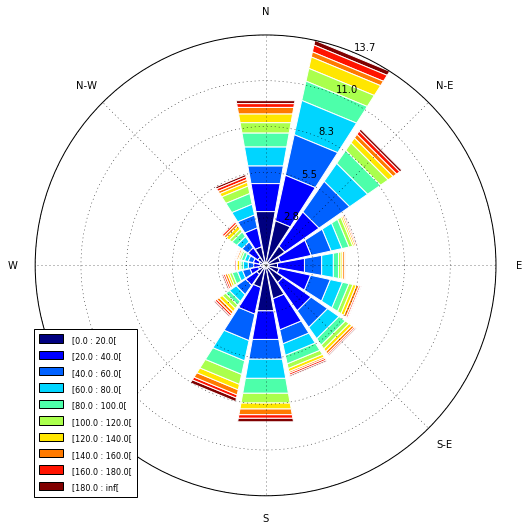

In [18]:
ax = WindroseAxes.from_ax()
ax.bar(df['direction'], df['speed'], bins=np.arange(0, 200, 20), normed=True, opening=0.9, edgecolor='white')
ax.set_legend()

An unclustered windrose would look like this:

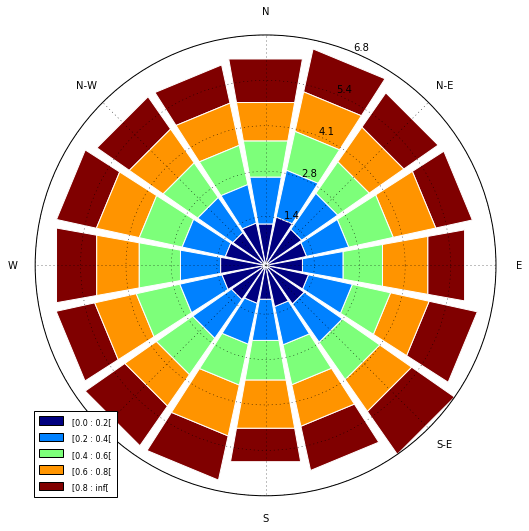

In [19]:
foo = pd.DataFrame(np.random.rand(10000, 2), columns=['speed', 'direction'])

foo['direction'] *= 360

ax = WindroseAxes.from_ax()
ax.bar(foo['direction'], foo['speed'], bins=[0, .2, .4, .6, .8], normed=True, opening=0.9, edgecolor='white')
ax.set_legend()